HF Zeeman Shifts

In [2]:
#### libraries
# %matplotlib notebook
from matplotlib import pyplot as plt
from sympy import symbols,N,sympify,lambdify
from sympy import MatrixSymbol,MatAdd,MatMul,Identity as eye,Matrix,zeros
from sympy.utilities.iterables import flatten
import numpy as np
from numpy import *
from numpy.linalg import eig
import math as m

#### local files
from rbconsts import *
from physconsts import *
from amophys import *
from conversions import *

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# Inuc = I # prevent weird stuff happening later?
# important: 'I' is the nuclear spin, not sympy imaginary i. Use
# numpy's 1j for imaginary i. 

In [3]:
#### Rb87 5s1/2 HF Zeeman Shifts:
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J

E_5sF2 = GHzToeV(2.56300597908911) # GHz
E_5sF1 = GHzToeV(-4.27167663181519) # GHz

gJ = gJ_fn(J,L,S,gL,gS)

Bzlist = np.linspace(0,.5,30)

# TODO: make hf energies above/below com energy
E_hf = GHzToeV(nu_hf) # assign numeric value to ease diagonalization (?)

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
H_a = zeros((8,8))
for i in range(8):
    if i < 5:
        H_a[i,i] = E_5sF2
    else: 
        H_a[i,i] = E_5sF1

# Zeeman Hamiltonian for B = Bz
H_Zz = np.empty((8,8),object)
basis = jmbasis(Flist)
for i,state_i in enumerate(basis):
        F,mF = state_i
        for j,state_j in enumerate(basis):
            FF,mFF = state_j
            states = [I,J,F,mF,FF,mFF]
            try:
                H_Zz[i,j] = hf_zeeman(states,gJ,gI)
            except:
                print("Failed: %s" % states)

# Diagonalize the full Hamiltonian
H = Matrix(H_a + H_Zz)
P,D = H.diagonalize()
evals = [D[i,i] for i in range(0,len(basis))]

# The energies as a function of magnetic P.E.
shifts = lambdify('U_B',evals)

zshifts = np.empty((len(Bzlist),len(basis)))
for i,Bz in enumerate(Bzlist):
    # make sure units of U_B same as E_hf then convert the whole shift
    zshifts[i] = np.sort([eVToGHz(x) for x in shifts(JToeV(uB*Bz))]) 
    
# arranged the shifts by state, not B value
zshifts = transpose(zshifts) 

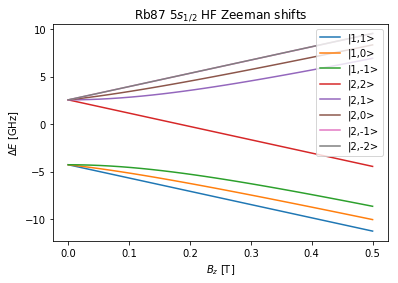

In [5]:
# initialize the figure and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Rb87 $5s_{1/2}$ HF Zeeman shifts")
ax.set_xlabel("$B_z$ [T]")
ax.set_ylabel("$\Delta E$ [GHz]")

# why is the |2,-1> state omitted?? figure out later
for state,shift in zip(basis,zshifts):
    F,mF = state
    ax.plot(Bzlist,shift,label=f'|{F},{mF}>')

ax.legend(loc='upper right')
plt.show()

In [6]:
# H_z1: static bias field
Bz = 5e-5 # .5 Gauss
H_z1_el = np.sort([eVToGHz(x) for x in shifts(JToeV(uB*Bz))]) 
H_bias = zeros((8,8))
for i in range(8):
    H_bias[i,i]=Hz_el[i]
    
# H_z1 microwave driving field
H_mw = zeros((8,8))
H_mw[1,5] = H_mw[5,1] = 1 # the rabi frequency


NameError: name 'Hz_el' is not defined

In [7]:
#### using my amophys module

#### Rb87 5s1/2 
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J

E_5sF2 = 2.56300597908911 # GHz
E_5sF1 = -4.27167663181519 # GHz

gJ = gJ_fn(J,L,S,gL,gS)

# Atom Hamiltonian in {|F,mF>} basis
dim = 2
H_a = zeros((dim,dim)) # clock states
H_a[0,0] = E_5sF2 # [J]
H_a[1,1] = E_5sF1 

# Zeeman Hamiltonian for bias field Bz
basis = [[2,0],[1,0]] # [F',mF'],[F,mF]
Bbias = .2*9.29e-4 # [A * G/A] see wiki 
H_Zz = hamiltonian_z1(basis,gI,gJ,Bz=Bbias,units='GHz')

# Diagonalize the static Hamiltonian
H = Matrix(H_a + H_Zz)
H = diagonal(H) # diagonalized with sorted e-vals

Failed: [1.5, 0.5, 2, 0, 2, 0]
2.00023 -0.000995 0.00018580000000000002
Failed: [1.5, 0.5, 2, 0, 1, 0]
2.00023 -0.000995 0.00018580000000000002
Failed: [1.5, 0.5, 1, 0, 2, 0]
2.00023 -0.000995 0.00018580000000000002
Failed: [1.5, 0.5, 1, 0, 1, 0]
2.00023 -0.000995 0.00018580000000000002


TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [21]:
(eVToGHz((H-H_a)[0,0]) - eVToGHz((H-H_a)[1,1]))*1e9

479083655.659906